In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
import numpy as np
import math

Single Module Experiment
---------------------------

In [35]:
from models.BGTC import Thalamus

# model parameters
n_populations = 2
n_synapses = 3
step_size = 1e-3
max_synaptic_delay = None
resting_potentials = [0., 0.]
connectivity_scaling = 20.
synapse_params = [dict(), {'efficacy': -0.001}, dict()]

# instantiate thalamus
thalamus = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                    connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)

# simulation parameters
simulation_time = 10.
cutoff_time = 5.
input_start = int(7.5 / step_size)
simulation_steps = int(simulation_time / step_size)

synaptic_input = np.zeros((simulation_steps, n_populations, n_synapses))
synaptic_input[:, 0, 0] += 2. * np.random.randn(simulation_steps) + 150.
synaptic_input[:, 0, 0] += 25.
synaptic_input[:, 1, 0] += 50.
synaptic_input[input_start:, 0, 0] += 15.
synaptic_input[input_start:, 1, 1] += 15. * 6.
synaptic_input[:, 1, 1] += 20.

# simulation
thalamus.run(synaptic_input, simulation_time)

/home/raid2/rgast/anaconda3/envs/mne_gpc/lib/python3.6/site-packages/PyRates-0.2-py3.6.egg/core/utility/bio_features.py:206: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((firing_rate - threshold) / steepness))


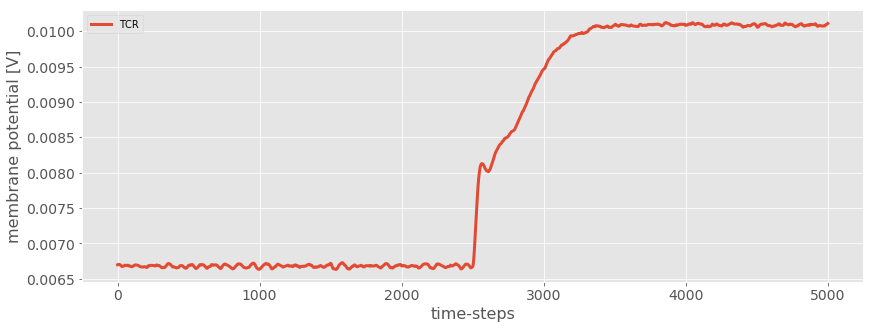

In [31]:
fig, axes = plt.subplots(figsize=(14,5))
axes = thalamus.plot_population_states([0], create_plot=False, axes=axes, time_window=[cutoff_time, simulation_time])

Two Coupled Modules
-----------------------

In [38]:
from core.circuit import CircuitFromCircuit

# create coupled thalamus model
###############################

# thalamus parameters
n_populations = 2
n_synapses = 3
step_size = 1e-3
max_synaptic_delay = None
resting_potentials = [0., 0.]
connectivity_scaling = 20.
synapse_params = [dict(), {'efficacy': -0.001}, dict()]

# thalamus objects
thalamus_1 = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                      connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)
thalamus_2 = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                      connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)

# connectivity
connectivity = np.zeros((2, 2, n_synapses))
connectivity[0, 1, 1] = 0.4 * connectivity_scaling
connectivity[1, 0, 1] = 0.4 * connectivity_scaling

# input and output populations
input_pops = np.ones((2, 2, 1), dtype=int).tolist()
output_pops = np.ones((2, 2), dtype=int)

# create coupled model
circuit = CircuitFromCircuit([thalamus_1, thalamus_2], connectivity=connectivity, input_populations=input_pops,
                             output_populations=output_pops, circuit_labels=['TH1', 'TH2'])

# perform simulation
####################

# simulation parameters
simulation_time = 10.
cutoff_time = 2.
input_start = int(5. / step_size)
simulation_steps = int(simulation_time / step_size)

synaptic_input = np.zeros((simulation_steps, 2 * n_populations, n_synapses))

# input to thalamus 1
synaptic_input[:, 0, 0] += 2. * np.random.randn(simulation_steps) + 150.
synaptic_input[:, 0, 0] += 25.
synaptic_input[:, 1, 0] += 50.
synaptic_input[input_start:, 0, 0] += 15.
synaptic_input[input_start:, 1, 1] += 15. * 6.
synaptic_input[:, 1, 1] += 20.

# input to thalamus 2
synaptic_input[:, 2, 0] += 2. * np.random.randn(simulation_steps) + 150.
synaptic_input[:, 2, 0] += 25.
synaptic_input[:, 3, 0] += 50.
synaptic_input[:, 3, 1] += 20.

# run simulation
circuit.run(synaptic_input, simulation_time)

/home/raid2/rgast/anaconda3/envs/mne_gpc/lib/python3.6/site-packages/PyRates-0.2-py3.6.egg/core/utility/bio_features.py:206: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((firing_rate - threshold) / steepness))


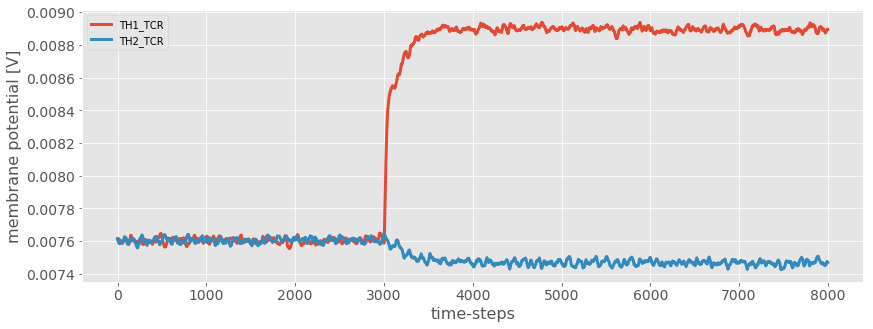

In [39]:
fig, axes = plt.subplots(figsize=(14,5))
axes = circuit.plot_population_states([0, 2], create_plot=False, axes=axes, time_window=[cutoff_time, simulation_time])